# Active learning of an unknown demand (bonus: Altair plots)

You're about to launch your product next month, but you're not sure which prices to use.
You think the demand has a log log form:

$$ \log q = \alpha + \beta \log p + \varepsilon $$

but you're unsure of the values of $\alpha$ and $\beta$

¿What should your pricing strategy be in this case? ¿How should you go about learning about demand, but without sacrificing too much profit in the meantime?

We can distinguish between two broad types of learning: active and passive.

Passive means you're choosing the optimal price according to your beliefs each period, without thinking about how your beliefs will evolve in the future. You'll still update your beliefs if reality gives you a surprise (say, demand was much higher than what your beliefs expected), but you won't take into account how the way you choose prices affect the rate of learning.

Active means you choose the optimal price as a compromise between exploitation and exploration: do you wanna try to maximize the current profits or do you wanna explore to learn faster / make sure you get the right answer? Thus, in active learning you need to take into account not just the current profits, but also how the current price choice changes the evolution of beliefs. In practice, this involves earning a bit less profit now, but getting more in the long run.

In this blog post, I will present a way of modeling this problem that I find particularly insightful and (relatively!) easy to code.

### Taking a stance

One way to model this problem is through dynamic programming and, more particularly, with a Bellman equation. Thus, the problem of choosing a sequence of prices under active learning can be written as:

$$V_{b_t}(I_t) = max_{p_t \in P} \{ \pi(p_t, x_t) + \beta
                 \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) b_t(x_{t+1}| p_t, I_t )\; d x_{t+1}\}  $$


+ $ \pi(a_t, x_t)$ is the current period profit
+ $x_{t+1}$ in this case is the log demand ($log q$)
+ $I_t$ represents the information set of the firm at $t$
+ $b_t(x_{t+1}| p_t, I_t )$ represents the firm's belief about the value that $x_{t+1}$ (log demand) will take next period

To fully flesh out this model, I borrow the notation of Aguirregabiria &amp; Jeon (2018): ["Firms' Belief and Learning in Oligopoly Markets"](http://aguirregabiria.net/wpapers/survey_rio.pdf)

The first important specification is what is the form of the belief function $b()$. In their survey paper, Aguirregabiria &amp; Jeon consider four types of learning and belief function

1. Rational expectations
2. Bayesian learning
3. Adaptive learning
4. Reinforcement learning

In this blog post I will only talk about Bayesian learning, but you're welcome to check the paper for the other approaches Under the bayesian learning, the firm starts with some priors on how $x_{t+1}$ (log demand) evolves and then updates those priors as new information (i.e. prices chosen and observed demand) comes in.

With the amazing Giovanni Ballarin (link here) we are writing the [LearningModel package](https://github.com/cdagnino/LearningModels) that estimates such value functions under different settings. Our idea is to make it easy for a researcher to plug different models and get a value function. For example, it should be easy to change the demand model from

$$ \log q = \alpha + \beta \log p + \varepsilon $$

to an AR(1) one

$$ \log q_{t} = \alpha + \beta \log p_{y} + \gamma q_{t-1} \varepsilon $$

without having to rewrite the value function iteration code completely.


### Example

We'll import the package and do a value function iteration to get the correct value function and policy functions.

With those in hand, we can simulate how would firms learn under a random demand scenario. We'll make all start with the same prior, but their experience with different demand realizations will make them behave and learn in a different way.




## Solve for the value and policy function

In [4]:
!git clone https://github.com/cdagnino/LearningModels.git
!mkdir LearningModels/data


Cloning into 'LearningModels'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 280 (delta 147), reused 167 (delta 38), pack-reused 0
Receiving objects: 100% (280/280), 876.49 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [ ]:
#If you get No module named 'src', you might need to add the folder to your system path
!python LearningModels/examples/aguirregabiria_simple.py

After 60 iterations we get an error of 0.004. We could let it run longer to get a smaller error, but it should be fine for our plotting purposes.

## Use the policy function to simulate

In [76]:
%matplotlib inline
import sys
sys.path.append("/Users/cd/Documents/github_reps/cdagnino.github.io/notebooks/LearningModels")

import matplotlib.pyplot as plt
import dill
import numpy as np
import pandas as pd
#file_n = "2018-10-1vfi_dict.dill"  
file_n = "2018-10-11vfi_dict.dill"
with open('LearningModels/data/' + file_n, 'rb') as file:
    data_d = dill.load(file)
    
    
import sys
sys.path.append('../')
import src

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']



lambdas_ext = src.generate_simplex_3dims(n_per_dim=15) #15 should watch value f iteration
print(lambdas_ext.shape)

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)

def one_run(lambda0=np.array([0.4, 0.4, 0.2]),
                             true_beta=src.betas_transition[2],
                             dmd_σϵ=src.const.σ_ɛ+0.05, time_periods=40):
    current_lambdas = lambda0
    d = {}
    d['level_prices'] = []
    d['log_dmd'] = []
    d['valueF'] = []
    d['lambda1'] = []
    d['lambda2'] = []
    d['lambda3'] = []
    d['t'] = []


    for t in range(time_periods):
        d['t'].append(t)
        d['lambda1'].append(current_lambdas[0])
        d['lambda2'].append(current_lambdas[1])
        d['lambda3'].append(current_lambdas[2])
        d['valueF'].append(valueF(current_lambdas[:2])[0])

        #0. Choose optimal price (last action of t-1)
        level_price = policyF(current_lambdas[:2]) #Check: Is this correctly defined with the first two elements?
        d['level_prices'].append(level_price[0])

        #1. Demand happens
        log_dmd = src.draw_true_log_dmd(level_price, true_beta, dmd_σε)
        d['log_dmd'].append(log_dmd[0])

        #2. lambda updates: log_dmd: Yes, level_price: Yes
        new_lambdas = src.update_lambdas(log_dmd, src.dmd_transition_fs, current_lambdas,
                       action=level_price, old_state=1.2)

        current_lambdas = new_lambdas
            
    return pd.DataFrame(d)

def many_runs(total_runs, **kwargs):
    dfs = []
    for run in range(total_runs):
        df = one_run(**kwargs)
        df['firm_id'] = run
        dfs.append(df)
        
    return pd.concat(dfs, axis=0)

all_firms = many_runs(7, time_periods=50)




(120, 3)


## Plot with your new BFF: Altair



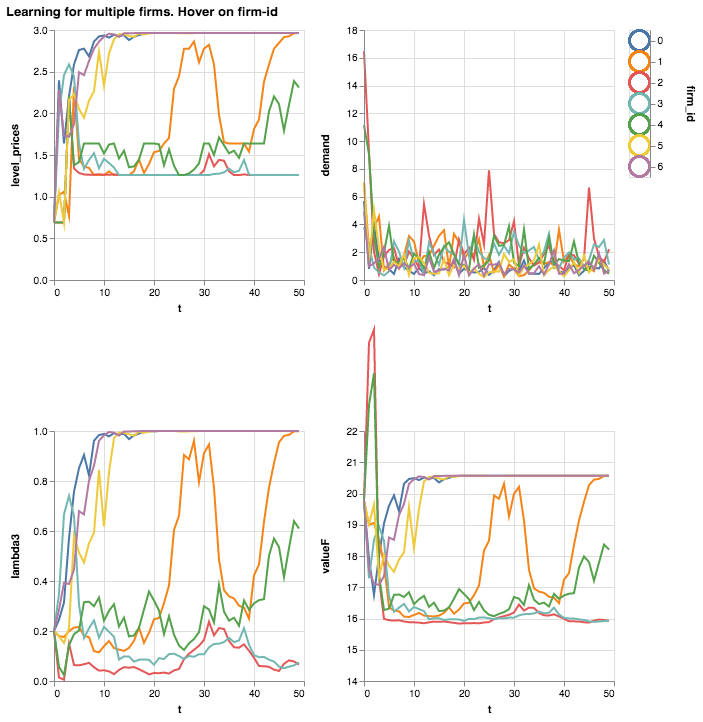

In [100]:
import altair as alt
all_firms['demand'] = np.e**(all_firms['log_dmd'])
selector = alt.selection_single(empty='all', fields=['firm_id'], on='mouseover')

base = alt.Chart(all_firms).properties(
    width=250,
    height=250
).add_selection(selector).transform_filter(
    selector
)

color_timeseries = alt.Color('firm_id:N', legend=None)

x_for_tseries = alt.X('t', scale=alt.Scale(domain=(0, 50)))

#alt.Y('level_prices', scale=alt.Scale(domain=(0, 3.5)))
timeseries1 = base.mark_line(strokeWidth=2).encode(
    x=x_for_tseries,
    y=alt.Y('level_prices'),
    color=color_timeseries
)

timeseries2 = base.mark_line(strokeWidth=2).encode(
    x=x_for_tseries,
    y=alt.Y('demand'),
    color=color_timeseries 
)

timeseries3 = base.mark_line(strokeWidth=2).encode(
    x=x_for_tseries,
    y=alt.Y('lambda3'),
    color=color_timeseries 
)

timeseries4 = base.mark_line(strokeWidth=2).encode(
    x=x_for_tseries,
    y=alt.Y('valueF', scale=alt.Scale(domain=(14, 22))),
    color=color_timeseries 
)


color = alt.condition(selector,
                      alt.Color('firm_id:N', legend=None, ),
                      alt.value('lightgray'))


legend = alt.Chart(all_firms).mark_point(size=400).encode(
    y=alt.Y('firm_id:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selector
)


((timeseries1 | timeseries2) & (timeseries3 | timeseries4) | legend).properties(
title='Learning for multiple firms. Hover on firm-id')



The true lambda that generated the demand data was lambda3. Because of this, a firm that learns correctly is one that puts probability one to lambda3.

The graph shows that some firms learnt this quite fast (firm 0, 5, 6), while others took longer or haven't converged to the right result after 50 periods (for example, firm 2 and 3).

If you select firm number 3, you can see why this might have happened: the demand is random and so big errors (the $\varepsilon$ in our demand equation) might make the demand appear **as if** the correct value is, say lambda2. If the firm is unlucky, it might get stuck in the wrong lambda for quite a while. However, we know that active learning is the correct approach and we're assured that the learning will eventually converge. This is not true if the firm were to use passive learning: in this case, there is a non trivial probability that the firm gets stuck forever in the wrong lambda. 


### Some notes on how to write this Altair interactive plot

If you're interested in Altair, I suggest you take a look at Jake Vanderplas' amazing tutorial [here](https://www.youtube.com/watch?v=ms29ZPUKxbU). In the meantime, I can give you some intuition on how the syntax works.


This graph has three components: the base graph (and the timeseries plots that come from it), a selector object and a legend.

Let's take a look at the base graph. The four time series graphs take this as the base.

```
base = alt.Chart(all_firms).properties(
    width=250,
    height=250
).add_selection(selector).transform_filter(
    selector
)
```

This tells `altair` to use the `all_firms` dataframe for the chart, specifies width, height and then adds both a selection mechanism and a `transform_filter` method. What does this do? It's telling `altair` to use the `selector`object to do some filtering. Thus, if a firm_id is selected in some way, only the date for that firm_id will be passed onto the graphs. I'll explain a bit more how this works below, but let's first take a look at one of four timeseries plots:


```
timeseries1 = base.mark_line(strokeWidth=2).encode(
    x=x_for_tseries,
    y=alt.Y('level_prices'),
    color=color_timeseries
)
```

We take the `base` graph we defined before and then use `mark_line`, which means we'll represent parts of the data as a line (instead of representing them as points, areas or whatnot). With the encoding, we tell `altair` to use a certain `x` and `y` axis and a color.


Now let's go back to the second component: the selector object.

```
selector = alt.selection_single(empty='all', fields=['firm_id'], on='mouseover')
```

A `selection_single` means we can only select one "thing". What kind of thing? One single `firm_id`. We will allow the selection to happen upon mouseover (as opposed, to, say, a click).


Finally, we have the legend. One of the cool things about `altair` is that you can create new objects and functionalities if you know how to combine the building blocks

```
legend = alt.Chart(all_firms).mark_point(size=400).encode(
    y=alt.Y('firm_id:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selector
)
```

If you pay attention, you'll see there's no `legend` function invoked. What I'm doing here is to encode the `firm_id` as points with some color. It's not a specially crafted `legend`function, it's just a set of points that can be used as a clickable legend now that I add the same `selector object`. Cool, right??

To finish our plot, we put all these elements together

```
((timeseries1 | timeseries2) & (timeseries3 | timeseries4) | legend).properties(
title='Learning for multiple firms. Hover on firm-id')
```

The `|` is used to put charts side by side and `&` to put one on top of the other.
